# Desription

+ Simulation of noise before and after matched filter
+ Filter is matched to rrc only in the first figure and to $\tilde{h}(t)$ in the second figure

# Import

In [1]:
# importing
import numpy as np

from scipy import signal

import matplotlib.pyplot as plt
import matplotlib

# showing figures inline
%matplotlib inline

In [2]:
# plotting options 
font = {'size'   : 20}
plt.rc('font', **font)
plt.rc('text', usetex=0)

matplotlib.rc('figure', figsize=(28, 8) )

# Initialization

### Get rrc impulse respone

In [3]:

########################
# find impulse response of an RRC filter
########################
def get_rrc_ir(K, n_sps, t_symbol, beta):
    
    ''' 
    Determines coefficients of an RRC filter 
    
    Formula out of: J. Huber, Trelliscodierung, Springer, 1992, S. 15
    
    NOTE: roll-off factor must not equal zero
    
    NOTE: Length of the IR has to be an odd number
    
    IN: length of IR, sps factor, symbol time, roll-off factor
    OUT: filter coefficients
    '''
    
    if beta == 0:
        beta = 1e-32
    
    K = int(K) 

    if ( K%2 == 0):
        raise ValueError('Length of the impulse response should be an odd number')
    
        
    # initialize np.array    
    rrc = np.zeros( K )
    
    # find sample time and initialize index vector
    t_sample = t_symbol / n_sps
    time_ind = range( -(K-1)//2, (K-1)//2+1)

    # assign values of rrc
    for t_i in time_ind:
        t = (t_i)* t_sample    

        if t_i == 0:
            rrc[ int( t_i+(K-1)//2 ) ] = (1-beta+4*beta/np.pi)

        elif np.abs(t) == t_symbol / ( 4 * beta ):             
            rrc[ int( t_i+(K-1)//2 ) ] = beta*np.sin( np.pi/(4*beta)*(1+beta) ) \
                - 2*beta/np.pi*np.cos(np.pi/(4*beta)*(1+beta)) 

        else:
            rrc[ int( t_i+(K-1)//2 ) ] = ( 4 * beta * t / t_symbol * np.cos( np.pi*(1+beta)*t/t_symbol ) \
                + np.sin( np.pi * (1-beta) * t / t_symbol ) ) / ( np.pi * t / t_symbol * (1-(4*beta*t/t_symbol)**2) )

    rrc = rrc  / np.sqrt(t_symbol)
               
    return rrc  

### Parameters

In [4]:
# parameters of the filter
beta = 0.33

n_sps = 8           # samples per symbol
syms_per_filt = 4  # symbols per filter (plus minus in both directions)

K_filt = 2 * syms_per_filt * n_sps + 1         # length of the fir filter

# set symbol time 
t_symbol = 1.0 

rrc = get_rrc_ir( K_filt, n_sps, t_symbol, beta )
rrc /= np.linalg.norm( rrc )

# constellation points equal to BPSK
constellation = [ -1, 1 ]

# Simulation

### Matching to RRC only

In [5]:
N_noise = int( 1e4 )

noise = np.random.randn(N_noise)
acf_noise = np.correlate( noise, noise, 'full' )
acf_noise /= np.linalg.norm( acf_noise )

noise_filtered = np.convolve( noise, rrc )
acf_filtered = np.correlate( noise_filtered, noise_filtered, 'full' )
acf_filtered /= np.linalg.norm( acf_filtered )

[ f_noise, psd_noise ] = signal.periodogram( acf_noise )
[ f_filtered, psd_filtered ] = signal.periodogram( acf_filtered )

<>:14: SyntaxWarning: invalid escape sequence '\O'
<>:24: SyntaxWarning: invalid escape sequence '\O'
<>:14: SyntaxWarning: invalid escape sequence '\O'
<>:24: SyntaxWarning: invalid escape sequence '\O'
/var/folders/g2/fvqz4zn95nd7kbhf6wdgn2dc0000gn/T/ipykernel_5245/3450464885.py:14: SyntaxWarning: invalid escape sequence '\O'
  plt.semilogy( Omega_noise, psd_noise, label='$\\Phi_{noise}(\Omega)$ (dB)' )
/var/folders/g2/fvqz4zn95nd7kbhf6wdgn2dc0000gn/T/ipykernel_5245/3450464885.py:24: SyntaxWarning: invalid escape sequence '\O'
  plt.semilogy( Omega_filtered, psd_filtered, label='$\\Phi_{filtered}(\Omega)$ (dB)' )


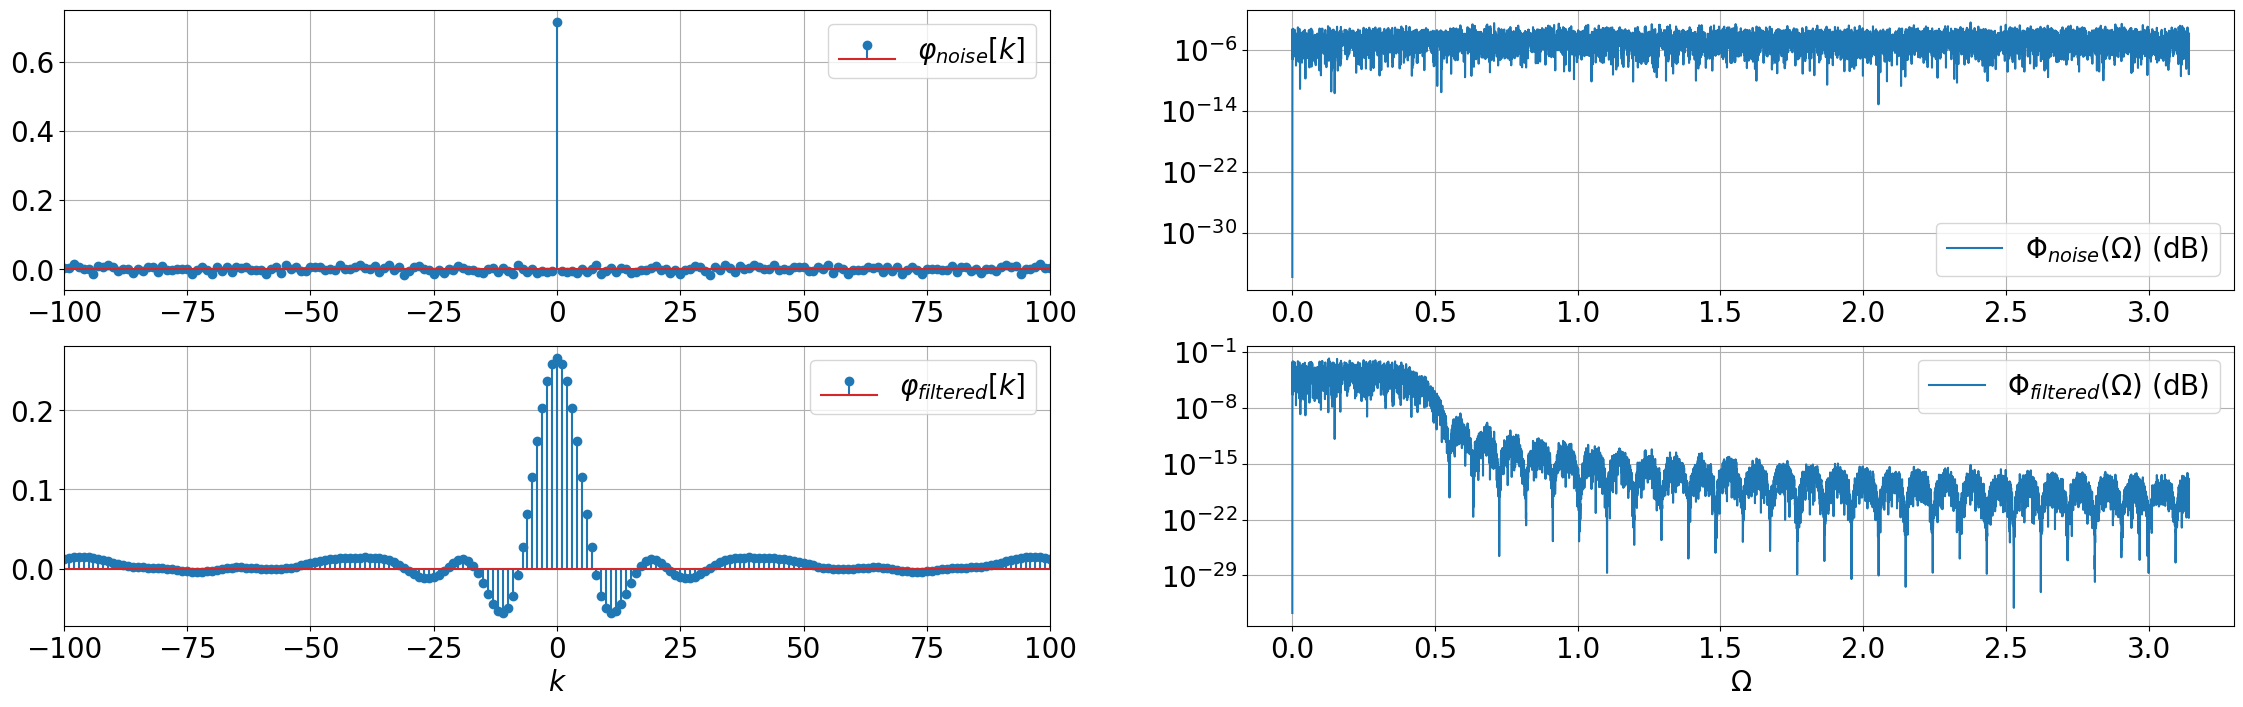

In [6]:
n = np.arange( -(N_noise-1), N_noise )
n_filtered = np.arange( -(N_noise-1+len(rrc)-1), N_noise+len(rrc)-1 )

Omega_noise = f_noise * 2 * np.pi
Omega_filtered = f_filtered * 2 * np.pi


plt.subplot(221) 
plt.stem( n, acf_noise, label='$\\varphi_{noise}[k]$' )
plt.xlim( (-100, 100));# plt.ylim((-.5, 1))
plt.grid(1); plt.legend()

plt.subplot(222)
plt.semilogy( Omega_noise, psd_noise, label='$\\Phi_{noise}(\Omega)$ (dB)' )
plt.grid(1); plt.legend()

plt.subplot(223) 
plt.stem( n_filtered, acf_filtered, label='$\\varphi_{filtered}[k]$' )
plt.xlim( (-100, 100)); #plt.ylim((-.5, 1))
plt.grid(1); plt.legend()
plt.xlabel('$k$')

plt.subplot(224)
plt.semilogy( Omega_filtered, psd_filtered, label='$\\Phi_{filtered}(\Omega)$ (dB)' )
plt.xlabel('$\\Omega$')
plt.grid(1); plt.legend()

### Now: matching to RRC and channel

### 

In [7]:

# define and apply channel 
channel_delays_syms = [0, 2]
channel_factors = [1.0, .5]

h_channel = np.zeros( (np.max(channel_delays_syms)+1)*n_sps )

for k in np.arange(len(channel_delays_syms)):
    h_channel[ n_sps*channel_delays_syms[k] ] = channel_factors[k]


# determine function h = rrc * h_C and subsequently function x (already sampled at symbol rate)
h = np.convolve(rrc, h_channel)
h /= np.linalg.norm(h)

In [8]:
N_noise = int( 1e4 )

noise = np.random.randn(N_noise)
acf_noise = np.correlate( noise, noise, 'full' )
acf_noise /= np.linalg.norm( acf_noise )

noise_filtered = np.convolve( noise, h )
acf_filtered = np.correlate( noise_filtered, noise_filtered, 'full' )
acf_filtered /= np.linalg.norm( acf_filtered )

[ f_noise, psd_noise ] = signal.periodogram( acf_noise )
[ f_filtered, psd_filtered ] = signal.periodogram( acf_filtered )

<>:14: SyntaxWarning: invalid escape sequence '\O'
<>:24: SyntaxWarning: invalid escape sequence '\O'
<>:14: SyntaxWarning: invalid escape sequence '\O'
<>:24: SyntaxWarning: invalid escape sequence '\O'
/var/folders/g2/fvqz4zn95nd7kbhf6wdgn2dc0000gn/T/ipykernel_5245/3815103414.py:14: SyntaxWarning: invalid escape sequence '\O'
  plt.semilogy( Omega_noise, psd_noise, label='$\\Phi_{noise}(\Omega)$ (dB)' )
/var/folders/g2/fvqz4zn95nd7kbhf6wdgn2dc0000gn/T/ipykernel_5245/3815103414.py:24: SyntaxWarning: invalid escape sequence '\O'
  plt.semilogy( Omega_filtered, psd_filtered, label='$\\Phi_{filtered}(\Omega)$ (dB)' )


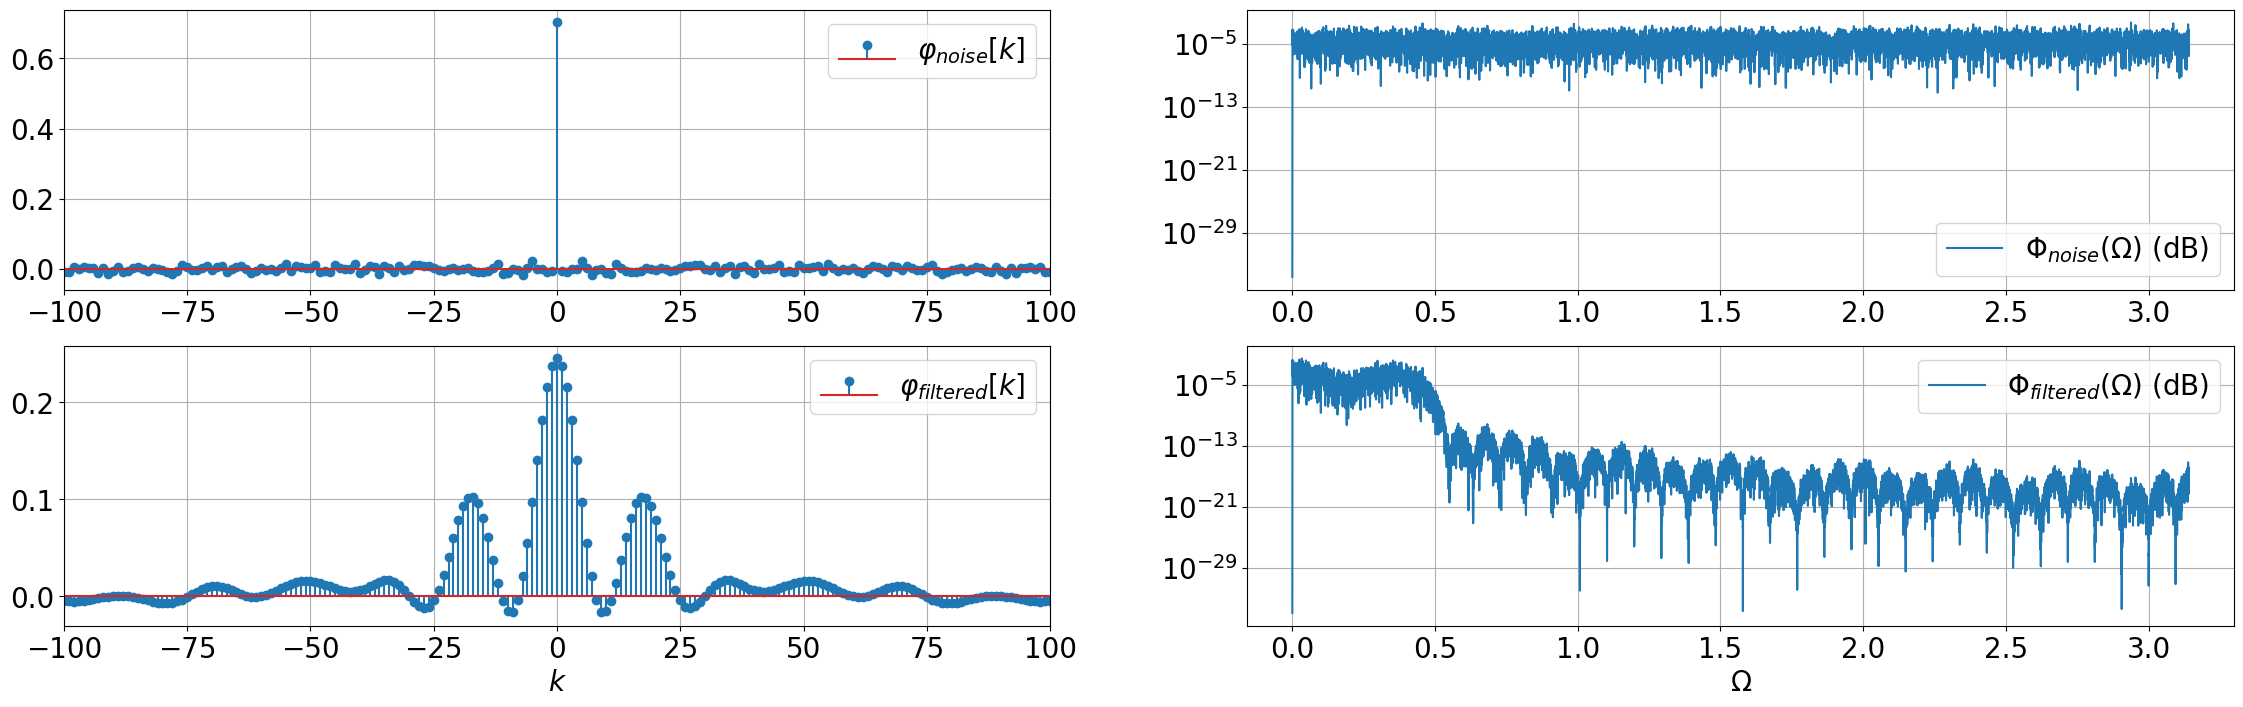

In [9]:
n = np.arange( -(N_noise-1), N_noise )
n_filtered = np.arange( -(N_noise-1+len(h)-1), N_noise+len(h)-1 )

Omega_noise = f_noise * 2 * np.pi
Omega_filtered = f_filtered * 2 * np.pi


plt.subplot(221) 
plt.stem( n, acf_noise, label='$\\varphi_{noise}[k]$' )
plt.xlim( (-100, 100));# plt.ylim((-.5, 1))
plt.grid(1); plt.legend()

plt.subplot(222)
plt.semilogy( Omega_noise, psd_noise, label='$\\Phi_{noise}(\Omega)$ (dB)' )
plt.grid(1); plt.legend()

plt.subplot(223) 
plt.stem( n_filtered, acf_filtered, label='$\\varphi_{filtered}[k]$' )
plt.xlim( (-100, 100)); #plt.ylim((-.5, 1))
plt.grid(1); plt.legend()
plt.xlabel('$k$')

plt.subplot(224)
plt.semilogy( Omega_filtered, psd_filtered, label='$\\Phi_{filtered}(\Omega)$ (dB)' )
plt.xlabel('$\\Omega$')
plt.grid(1); plt.legend()